In [672]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
import pickle
import csv
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing my already scaled data and importing my scaler

In [673]:
X_train_sc = pd.read_csv('../data/X_train_sc.csv', header=None)
X_test_sc = pd.read_csv('../data/X_test_sc.csv', header=None)
y_train = pd.read_csv('../data/y_train.csv', header=None)
y_test = pd.read_csv('../data/y_test.csv', header=None)
df = pd.read_csv('../data/clean_data.csv')
X = pd.read_csv('../data/X.csv')
with open('../assets/scaler.pkl', 'rb') as f:
    ss = pickle.load(f)

# Instantiaing  and fitting my model

In [674]:
X_train_sc.shape

(1538, 158)

In [675]:
lasso = LassoCV(n_alphas = 500)
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

# Scoring my model on train and test data

In [676]:
lasso.score(X_train_sc, y_train)

0.8645734109013203

In [677]:
lasso.score(X_test_sc, y_test)

0.9064780317626364

# Calculating RMSE for train and test data

In [678]:
y_hat_train = lasso.predict(X_train_sc)
y_hat_test = lasso.predict(X_test_sc)

In [679]:
mean_squared_error(y_train, y_hat_train) ** .5

29266.16138124954

In [680]:
mean_squared_error(y_test, y_hat_test) ** .5

23963.038158897227

In [681]:
lasso.intercept_

181061.9934980494

# Saving model and loading my columns

In [682]:
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

In [683]:
with open('../assets/lasso.pkl', 'wb+') as f:
    pickle.dump(lasso, f)

# Creating a dataframe of coefficients to see their weight

In [684]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=False).head(10)

,weight
Gr Liv Area,18626.848970
Overall Qual,18197.843328
Garage Cars_3.0,8402.124991
Kitchen Qual_Ex,7848.841800
Year Built,6699.902173
Bsmt Qual_Ex,5481.670432
Bsmt Exposure_Gd,4559.268453
Screen Porch,4000.026881
Bldg Type_1Fam,3322.041062
Year Remod/Add,3258.152995


In [685]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=True).head(10)

,weight
Bsmt Full Bath_0.0,-4059.005968
Fireplaces_0,-3462.741652
Exter Qual_TA,-2462.723404
Neighborhood_Edwards,-2215.880384
BsmtFin Type 1_Unf,-1896.489284
MS Zoning_RM,-1440.979778
Pool Area,-1223.627238
Kitchen Qual_TA,-815.015865
Overall Qual_6,-528.673226
Lot Shape_Reg,-248.197413


# Creating plots based on my model (for presentation)

In [686]:
y = df['SalePrice']

In [687]:
df_new = X[columns]

In [688]:
df_new_fit= ss.transform(df_new)

In [689]:
df_new['predictions'] = lasso.predict(df_new_fit)

In [690]:
df_new['SalePrice'] = y

Text(0,0.5,'Sale Price')

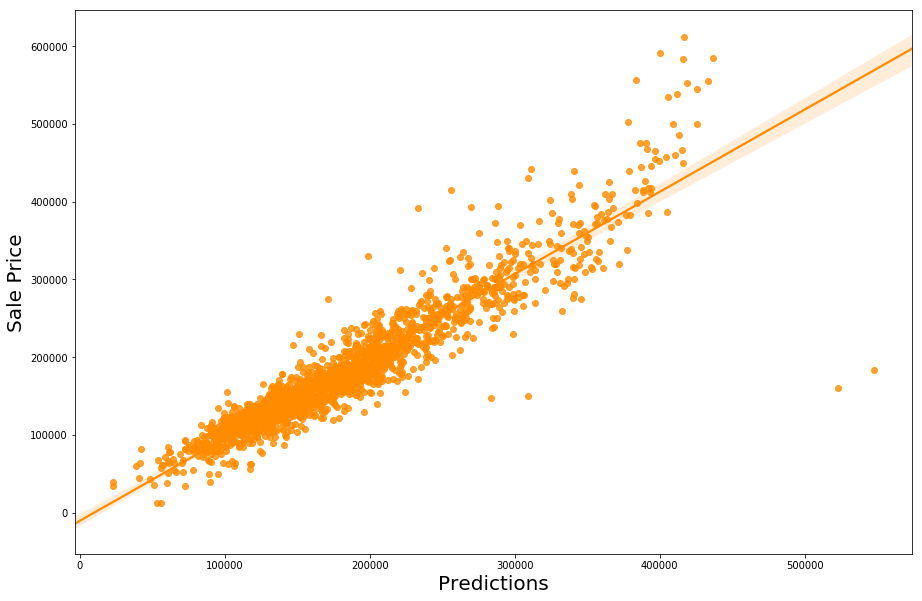

In [691]:
plt.figure(figsize=(15,10))
sns.regplot(x = 'predictions', y = 'SalePrice', data=df_new, color = 'darkorange')
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Sale Price', fontsize=20)

# Observing outliers

In [692]:
mask1 = df_new['SalePrice']<200_000
mask2 = df_new['predictions']>500_000
df_new[mask1 & mask2]


,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,...,Mo Sold_10,Yr Sold_2006,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,Sale Type_New,Sale Type_WD,predictions,SalePrice
960,908154235,313.0,63887,10,5,2008,2008,796.0,466.0,6110.0,...,0,0,0,1,0,0,1,0,522817.308529,160000
1885,908154195,128.0,39290,10,5,2008,2009,1224.0,1085.0,5095.0,...,1,0,1,0,0,0,1,0,547599.915236,183850


# Creating a data frame of all coefficients and their absolute value

In [693]:
betas = pd.DataFrame(lasso.coef_, index = columns)

In [694]:
betas.columns = ['weight']

In [695]:
betas['absolute_weight'] = betas.weight.abs()

In [696]:
betas.head()

,weight,absolute_weight
PID,-0.000000,0.000000
Lot Frontage,0.000000,0.000000
Lot Area,2183.557820,2183.557820
Overall Qual,18197.843328,18197.843328
Overall Cond,2233.962153,2233.962153


In [697]:
weights = betas.sort_values('absolute_weight', ascending=False)['weight'].head(20)

In [698]:
4.640995e+07

46409950.0

In [699]:
labels = weights.index

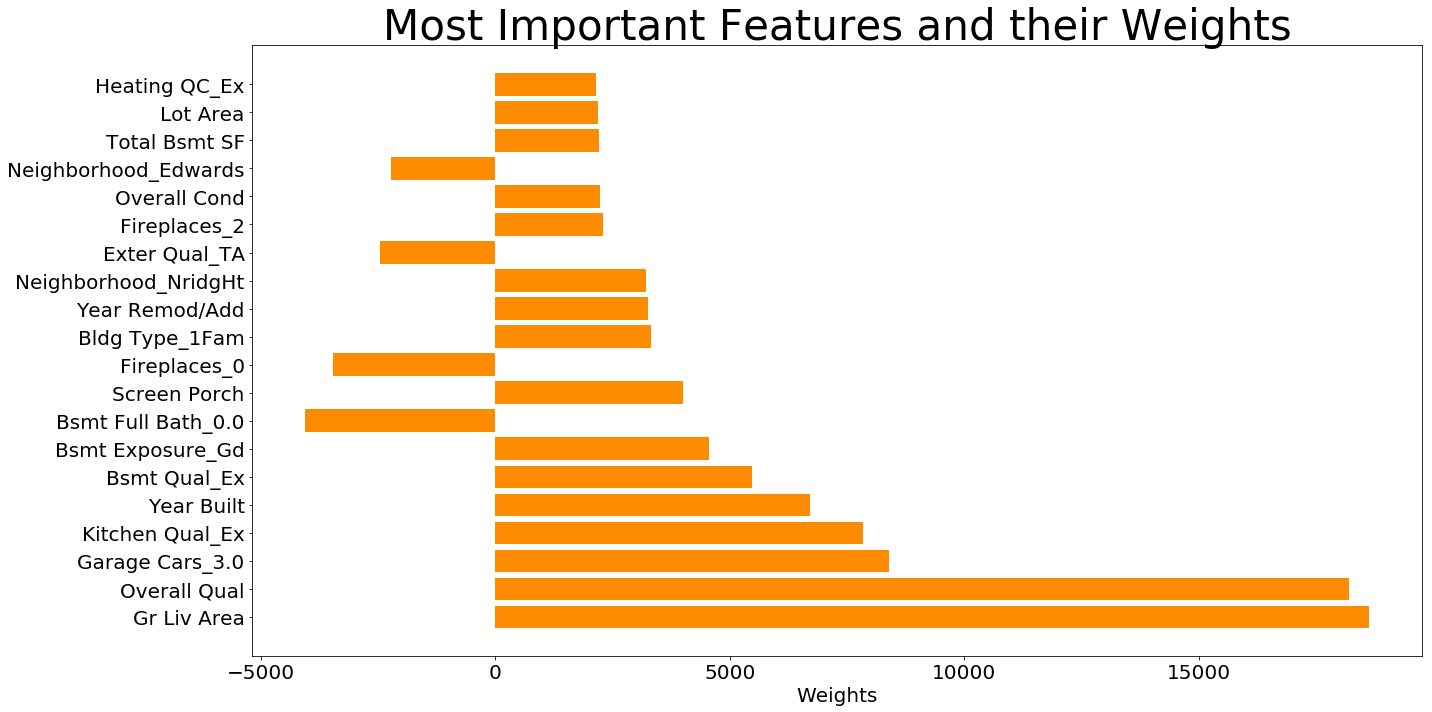

In [700]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'darkorange')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=20)
plt.title('Most Important Features and their Weights', fontsize=42)
plt.tight_layout()

# Creating line plots to examine specific features and their sales price

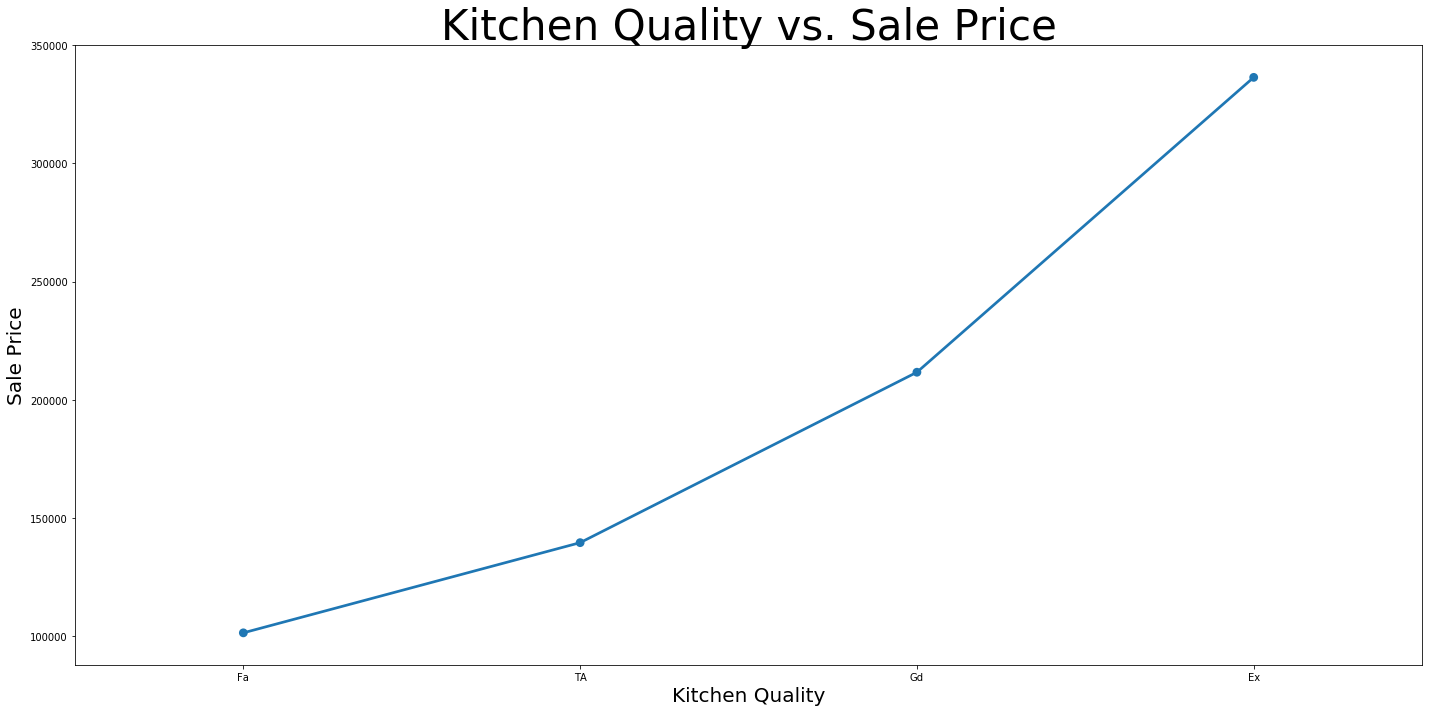

In [701]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Kitchen Qual', y = 'SalePrice', data =df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Kitchen Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title('Kitchen Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

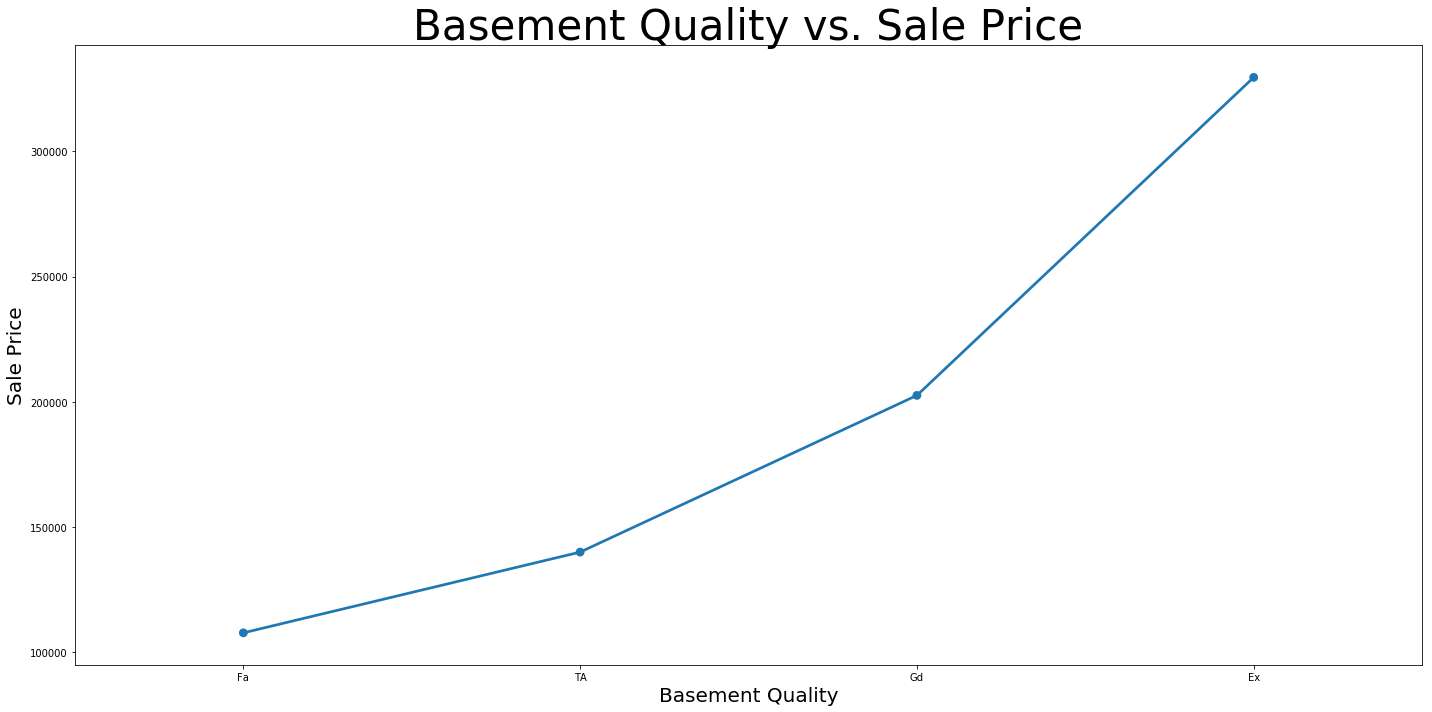

In [702]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Bsmt Qual', y = 'SalePrice', data = df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Basement Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title('Basement Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

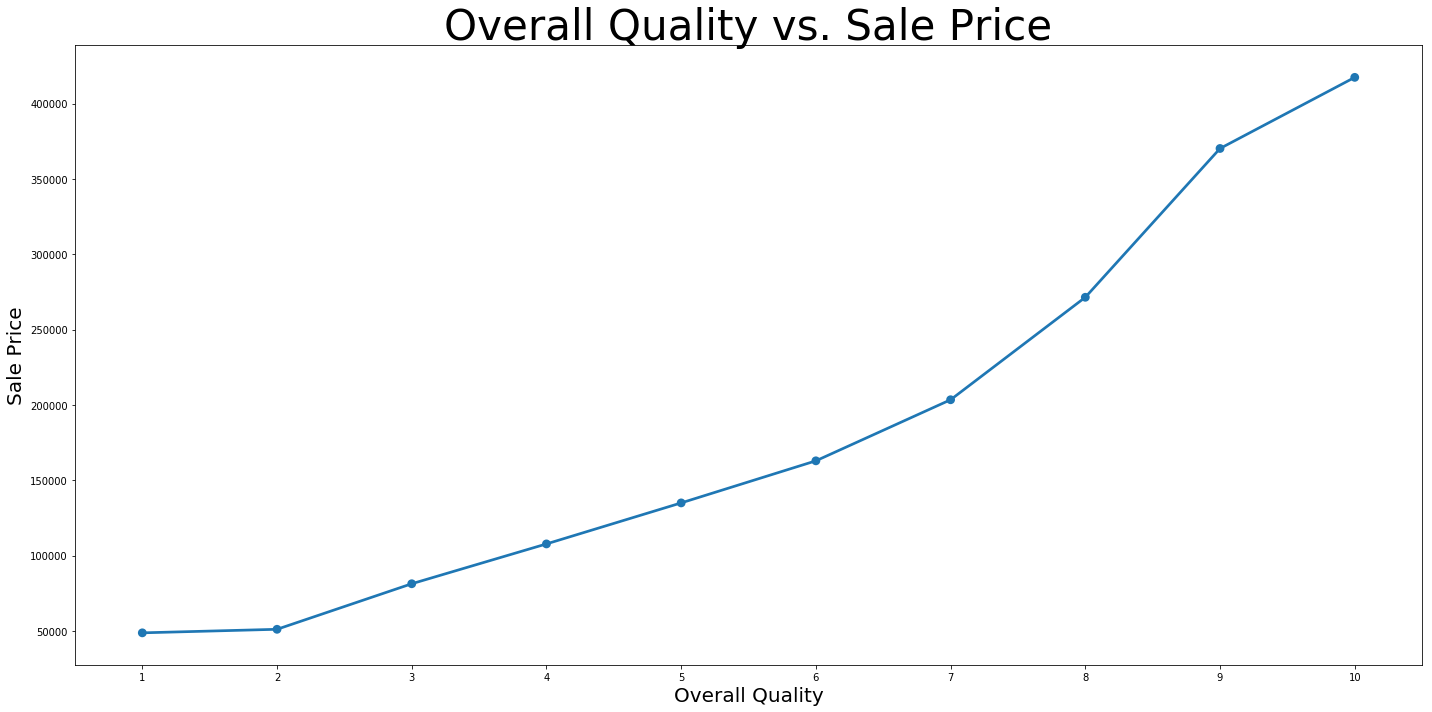

In [703]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Overall Qual', y = 'SalePrice', data = df, 
              orient = 'v', ci = 0)
plt.xlabel('Overall Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title('Overall Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

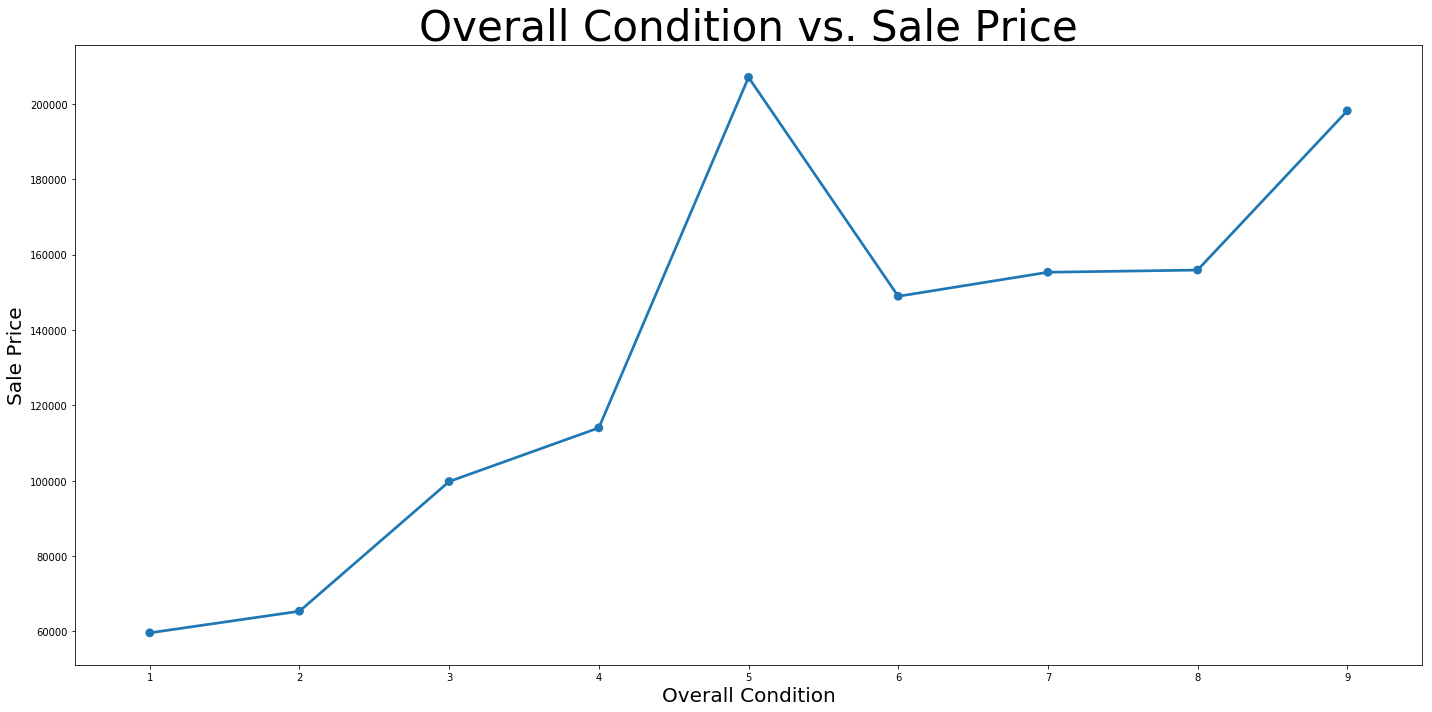

In [704]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Overall Cond', y = 'SalePrice', data =df, 
              orient = 'v', ci = 0)
plt.xlabel('Overall Condition',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title('Overall Condition vs. Sale Price', fontsize=42)
plt.tight_layout()

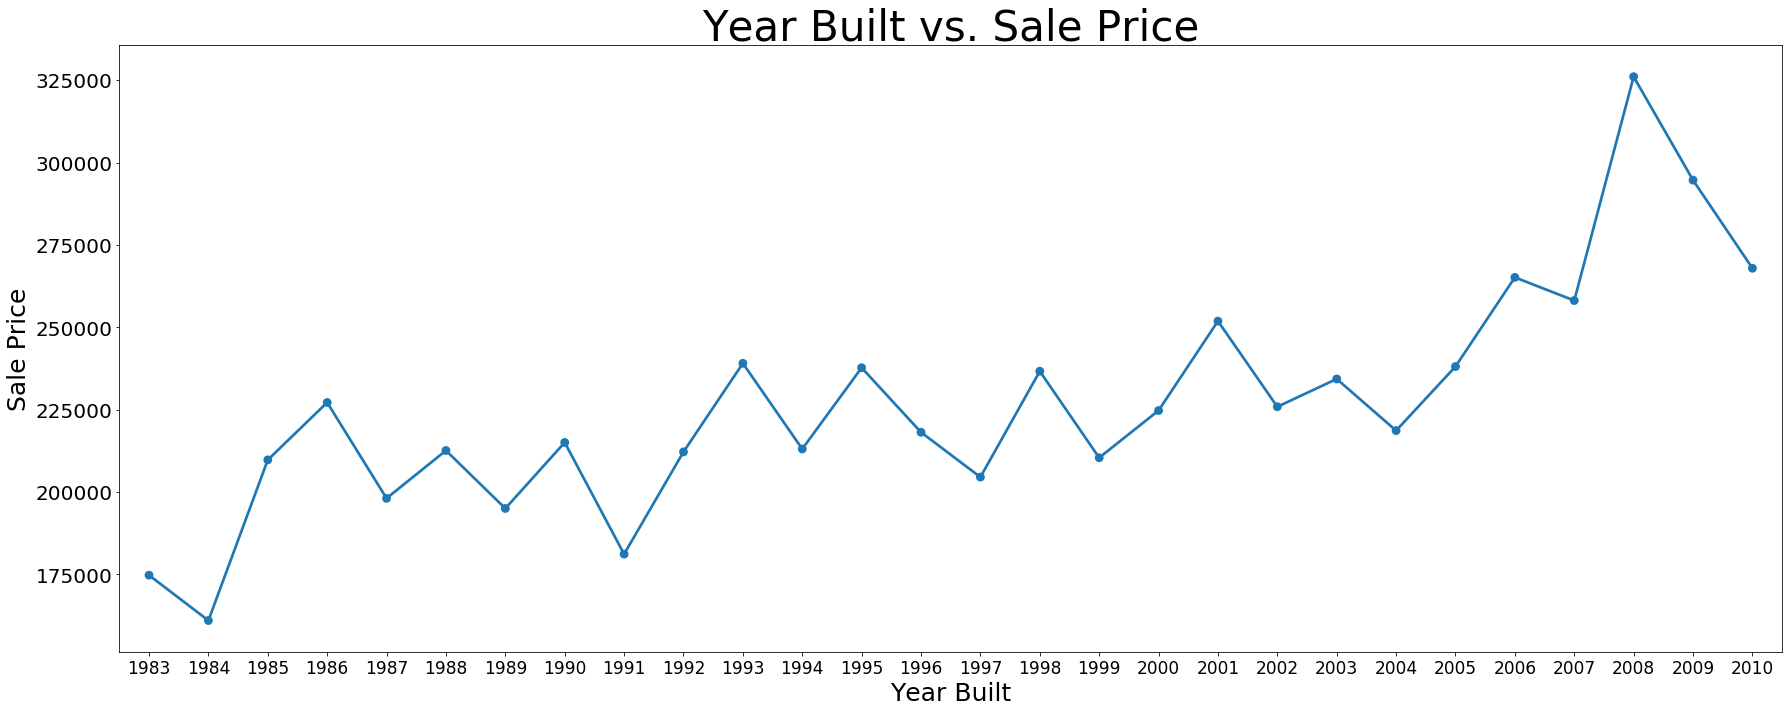

In [705]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'Year Built', y = 'SalePrice', data =df[df['Year Built'] > 1982], 
              orient = 'v', ci = 0)
plt.xlabel('Year Built',fontsize=25)
plt.ylabel('Sale Price',fontsize=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=20)
plt.title('Year Built vs. Sale Price', fontsize=42)
plt.tight_layout()

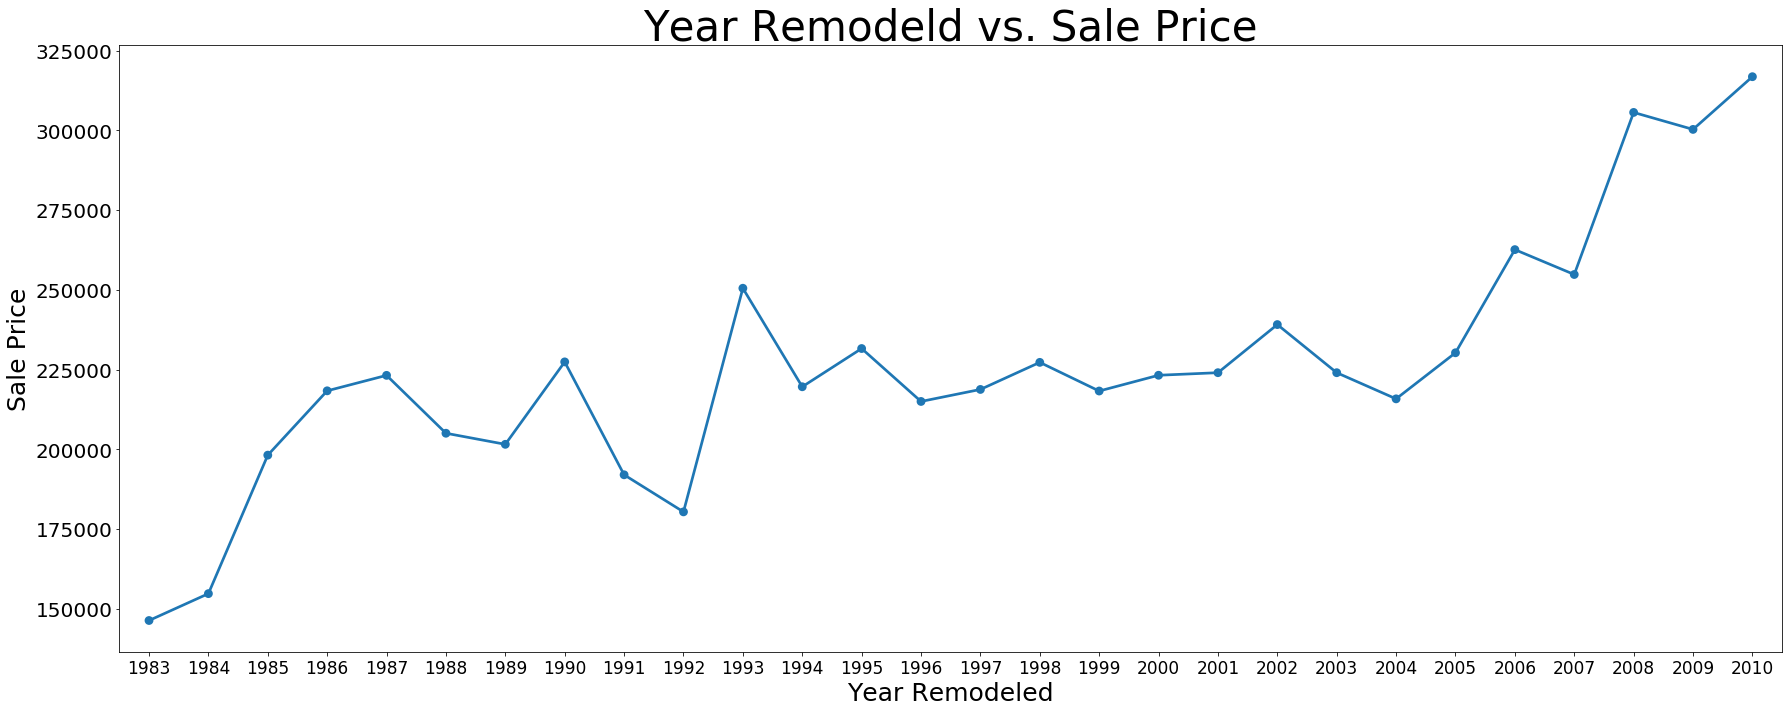

In [706]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'Year Remod/Add', y = 'SalePrice', data =df[df['Year Built'] > 1982], 
              orient = 'v', ci = 0)
plt.xlabel('Year Remodeled',fontsize=25)
plt.ylabel('Sale Price',fontsize=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=20)
plt.title('Year Remodeld vs. Sale Price', fontsize=42)
plt.tight_layout()